# Tutorial 03 - Deep Unfolding with a regression model

In [17]:
import uproot
import numpy

In [2]:
f_train = uproot.open( "/Users/jdb/bnl/work/MLatSTAR/train.root" )

In [4]:
f_train.allkeys()

[b'fPtRes;1',
 b'fCrystalBall;1',
 b'fMultEff;1',
 b'fVzEff;1',
 b'fZDC;1',
 b'mult;2',
 b'mult;1',
 b'hmc_Pt;1',
 b'hmc_Eta;1',
 b'hmc_Mult;1',
 b'hrc_Pt;1',
 b'hrc_Eta;1',
 b'hrc_Mult;1',
 b'hMult;1',
 b'hMultTof;1',
 b'hMultBEMC;1']

In [6]:
tree = f_train[b'mult']

In [7]:
tree.show()

reco_mult                  (no streamer)              asdtype('>f4')
tof_mult                   (no streamer)              asdtype('>f4')
bemc_mult                  (no streamer)              asdtype('>f4')
vz                         (no streamer)              asdtype('>f4')
zdcx                       (no streamer)              asdtype('>f4')
mult                       (no streamer)              asdtype('>f4')


In [8]:
arrays = tree.arrays( ["mult", "reco_mult", "tof_mult", "bemc_mult", "vz", "zdcx"] )

In [9]:
arrays

{b'mult': array([325.,   1., 173., ...,  58.,  73.,  45.], dtype=float32),
 b'reco_mult': array([31.,  1., 44., ..., 17., 30., 21.], dtype=float32),
 b'tof_mult': array([108.,   1.,  39., ...,  16.,  22.,  18.], dtype=float32),
 b'bemc_mult': array([5., 0., 3., ..., 0., 1., 0.], dtype=float32),
 b'vz': array([ 34.962646 ,  26.977768 ,  43.881706 , ..., -62.19352  ,
        -59.450607 ,   2.9815679], dtype=float32),
 b'zdcx': array([44887., 49857., 56948., ..., 62706., 68823., 64753.], dtype=float32)}

In [10]:
import matplotlib.pyplot as plt
fs = ( 32, 18 ) # lets make all our figures 16 by 9

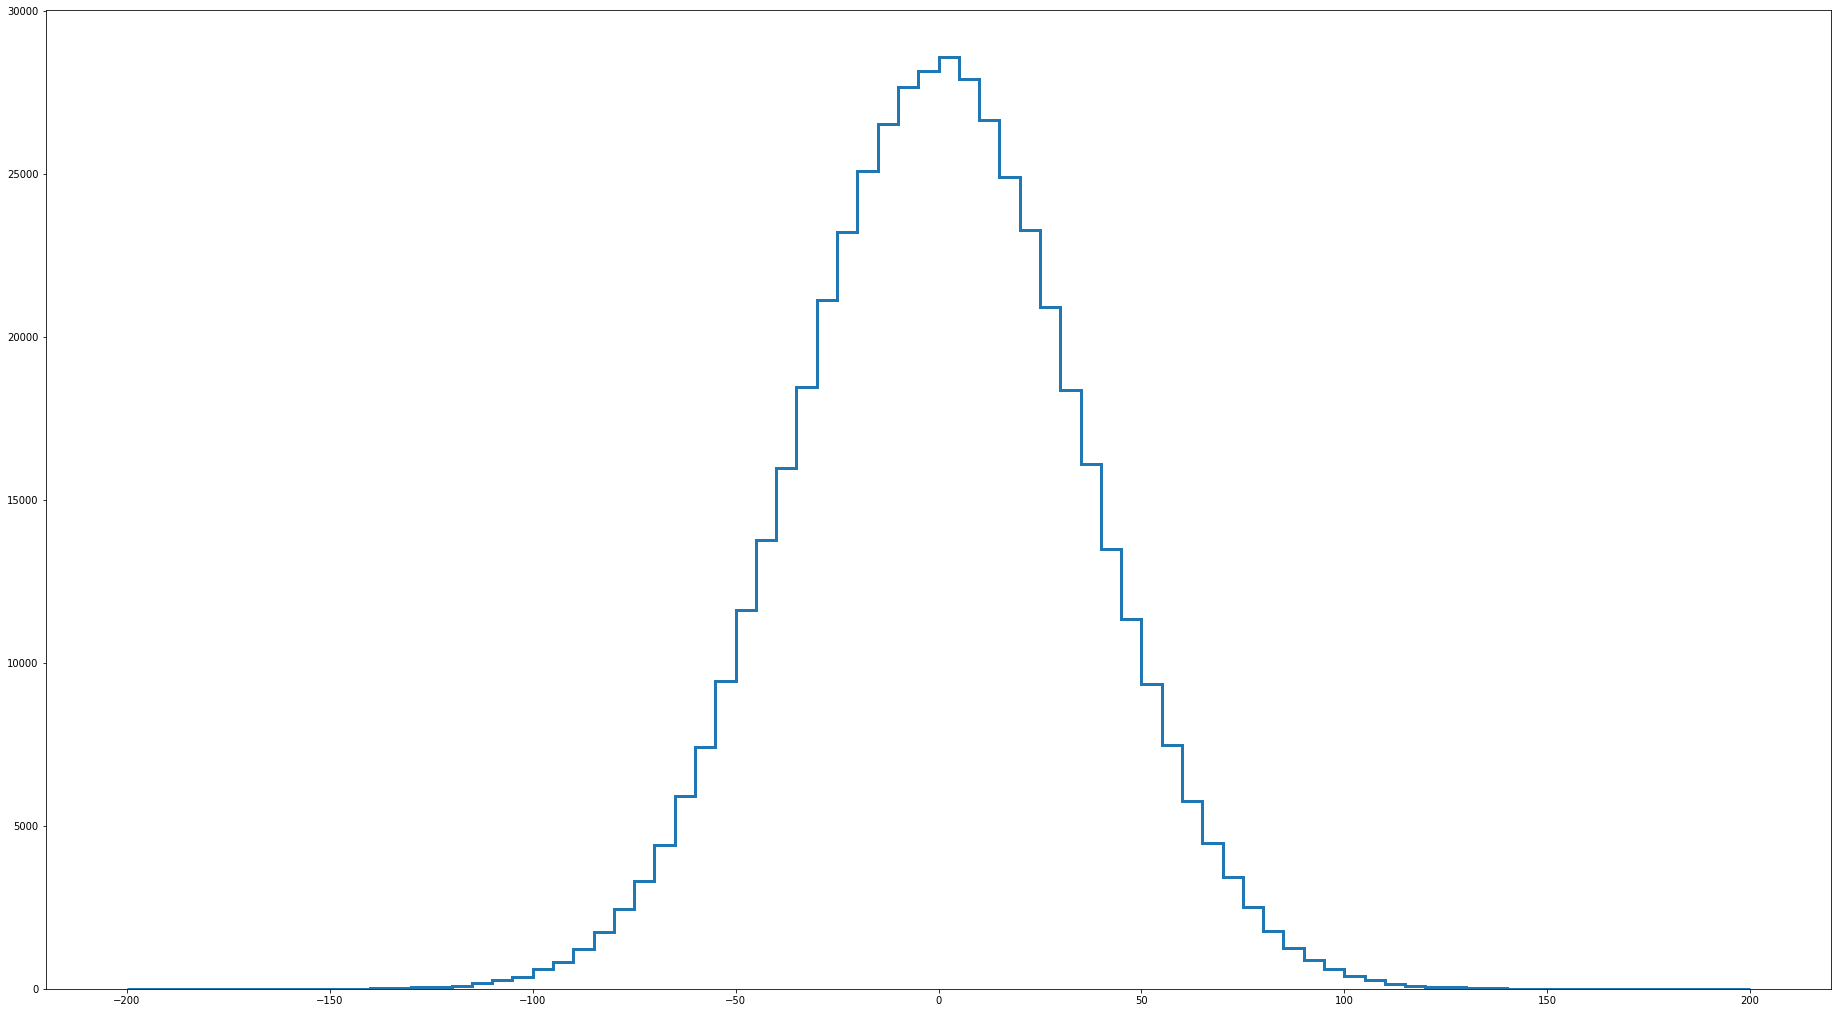

In [28]:
plt.figure(figsize=fs)
plt.hist( arrays[b"vz"].flatten(), bins=range(-200, 205, 5), fill=False, histtype='step', linewidth=3 );

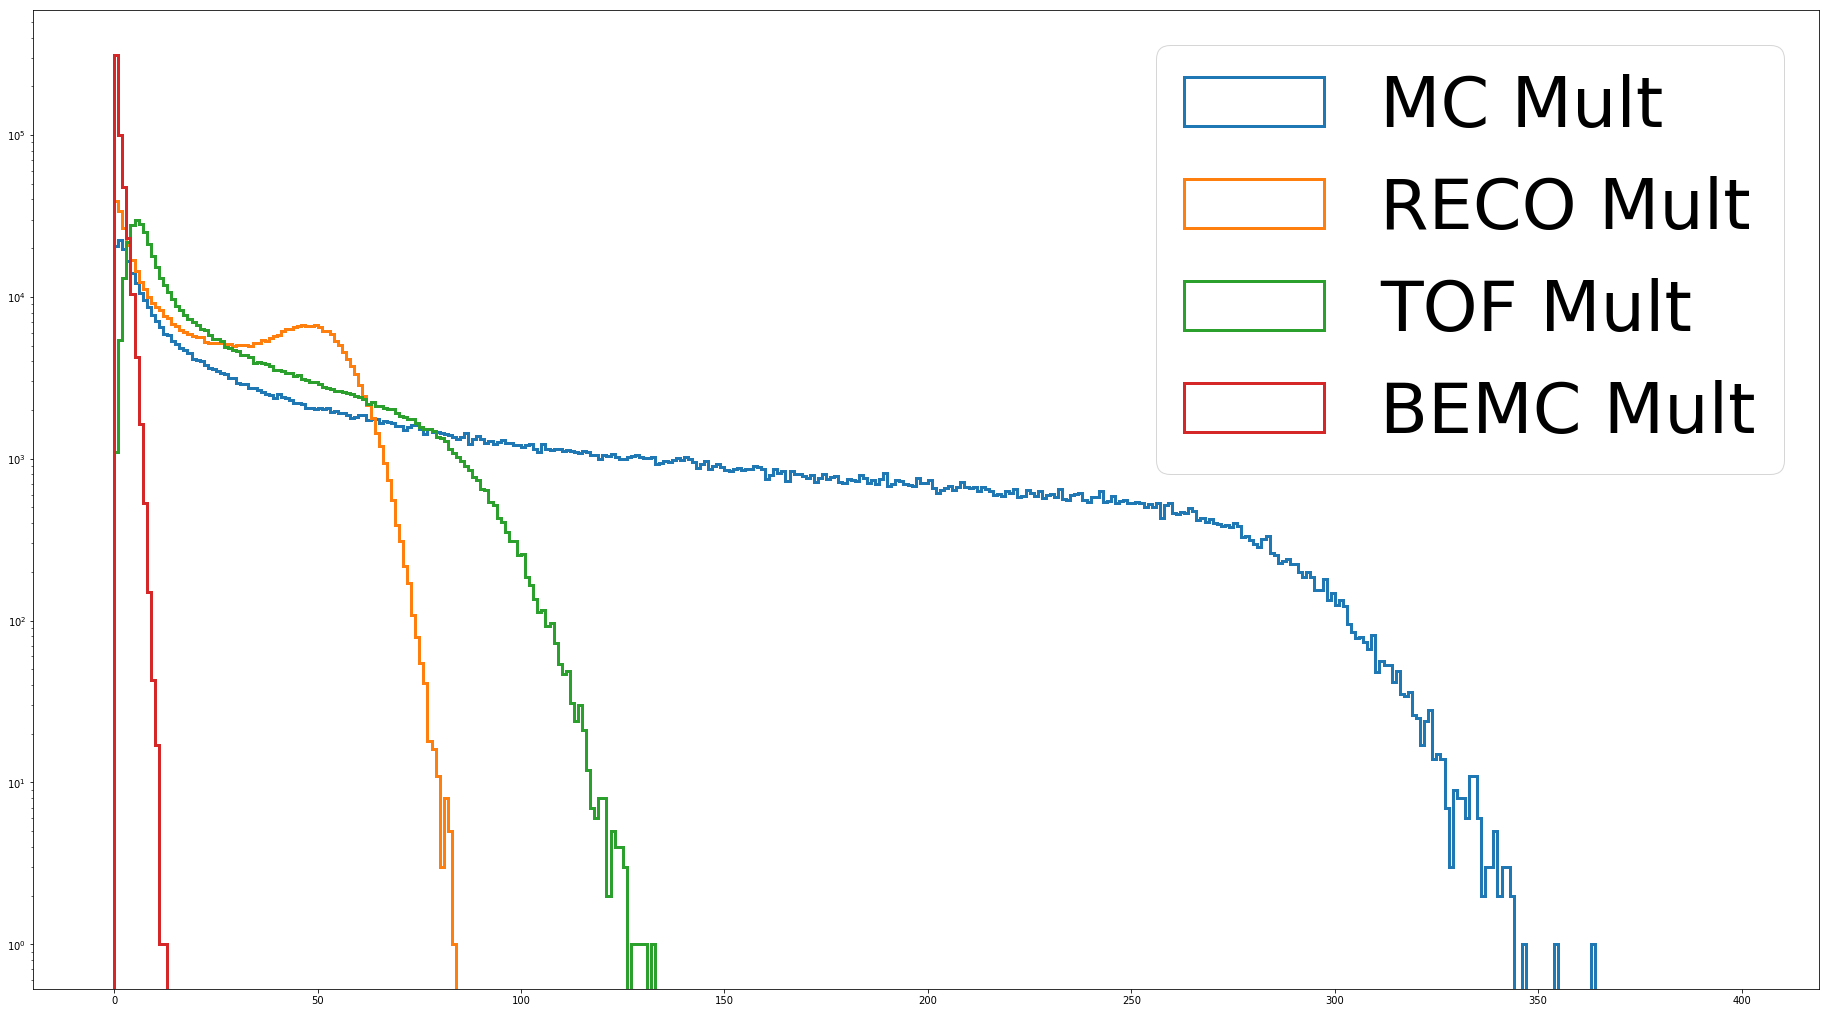

In [27]:
plt.figure(figsize=fs)
plt.hist( arrays[b"mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="MC Mult", linewidth=3 );
plt.hist( arrays[b"reco_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="RECO Mult", linewidth=3 );
plt.hist( arrays[b"tof_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="TOF Mult", linewidth=3 );
plt.hist( arrays[b"bemc_mult"].flatten(), bins=numpy.arange(0, 400, 1), fill=False, histtype='step', label="BEMC Mult", linewidth=3 );
plt.yscale('log')
plt.gca().legend(prop={'size': 70})

## Train a model with Keras

In [1]:
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor


ModuleNotFoundError: No module named 'tensorflow'